In [63]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from PIL import Image
from PIL import ImageOps
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from tqdm.notebook import tqdm
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
import cv2
import warnings
warnings.filterwarnings("ignore")

### Função de treinamento

In [64]:
def make_train(X, Y, pipeline, param_grid, alg):
    kfolds = KFold(n_splits=X.shape[0])

    grid = RandomizedSearchCV(pipeline, param_grid, n_jobs=-1, cv=kfolds, return_train_score=False, n_iter=10)

    grid_train = grid.fit(X, Y)
    scores = grid_train.score(X, Y)
    
    filename = 'models/'+alg+'_model.sav'
    pickle.dump(grid_train, open(filename, 'wb'))

    print("CV results\n", grid.cv_results_)
    print()
    print("Optimal hyperparameter combination: ", grid.best_params_)
    print("Best model time", grid.refit_time_)
    print("\nScore mean: ", scores)
    return grid_train.best_params_, scores 

### Carregamento dos dados

In [65]:
X_pca = pd.read_csv('data/df_X_pca.csv')
X_pca

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,8575.369720,3070.524971,-5834.143007,6041.903850,896.143775,1417.693965,-485.812639,765.273835,-1207.929461,-1121.759344,...,258.117607,14700.347795,1958.645958,-10313.205052,4081.031869,-5209.716191,-3138.701174,-1018.359123,-4569.791910,-6887.447276
1,9679.597132,1825.457559,-5874.524262,5774.953071,456.276528,-187.326118,-548.018905,233.029544,-801.621263,-708.571336,...,-1105.907216,4005.216775,2149.134728,6729.341701,5223.231334,4851.383722,-906.551946,753.210036,-1781.364371,-5430.509158
2,5140.225289,1010.205323,-5248.842179,6767.753044,585.302308,516.785563,-1304.903072,-178.350951,-106.118566,380.217382,...,2259.122872,4081.514699,-1819.467997,-663.467782,2213.522834,-1075.488922,-838.599804,223.490913,-440.776344,-528.692788
3,11143.616299,3326.860327,-6677.077579,6730.435734,868.376165,933.053788,-1822.858130,327.489657,-1922.783710,-642.230006,...,-25003.306512,68772.814441,16590.965216,1617.654469,21805.590825,-6436.197925,-9132.980911,578.260075,-788.046211,-15668.102208
4,-2544.011236,678.761593,-4078.725019,8763.533243,1362.667068,1398.862080,-737.008036,-153.169863,-997.534822,-872.013538,...,734.832060,1507.914649,1074.141603,-1572.540624,1376.820240,-117.704924,-1714.522103,363.290151,322.632996,409.054338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,-6293.970933,43.774065,-3180.195687,3326.565254,765.422472,67.415924,-1291.234168,-2086.646653,-127.183182,-1151.312870,...,334.010906,444.921405,-446.680845,-315.807063,255.394959,-1213.880817,-718.529565,25.525339,298.954723,-283.521485
77,-19640.111793,-982.024066,-625.748192,10615.746189,-1235.083357,-129.668486,-4935.725094,464.035698,-2353.403902,-1869.686250,...,291.111470,-219.926875,632.697772,-224.378219,-71.587421,938.025916,311.096857,1058.311625,-54.253733,-626.112420
78,-3041.945781,1231.509474,-4842.242258,9213.770666,974.612547,1364.455212,-660.800482,-755.636064,-2010.142220,388.749788,...,948.167227,-320.467029,757.325329,956.827461,1326.988148,656.933063,-996.753908,1273.220744,616.220869,1168.687265
79,-2853.134506,329.939437,-3976.584491,2789.172669,1723.763440,179.693305,-534.506817,-447.008752,-764.375904,-924.638145,...,-577.674023,164.376149,-1660.001356,542.749668,-641.439439,692.420489,-1095.162753,-1752.107641,258.941124,-211.858706


In [66]:
X_pca.shape

(81, 70)

In [67]:
Y = pd.read_csv('data/df_Y.csv')
Y

,class
0,brachiaria decumbens
1,brachiaria decumbens
2,brachiaria decumbens
3,brachiaria decumbens
4,brachiaria decumbens
...,...
76,brachiaria humidicola
77,brachiaria humidicola
78,brachiaria humidicola
79,brachiaria humidicola


In [68]:
label_encoder = LabelEncoder()
Y_encoder = label_encoder.fit_transform(Y)
Y_encoder

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [69]:
np.random.seed(42)

In [70]:
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y_encoder, test_size = 0.3, random_state=42)

### Treinamento dos algoritmos

#### Random Forest

##### Abordagem PCA

In [71]:
pipeline = Pipeline(steps=[("rf", RandomForestClassifier(n_jobs=-1, criterion='entropy'))])

param_grid = {'rf__max_depth': range(2, 100),
              'rf__min_samples_split': range(2, 100)
             }

In [72]:
rf_pca_model, rf_pca_scores = make_train(X_train, Y_train, pipeline, param_grid, 'rf_just_pca')

CV results
 {'mean_fit_time': array([0.47497581, 0.49033464, 0.50462859, 0.40601384, 0.41045798,
       0.35221255, 0.31840681, 0.36919319, 0.36310463, 0.34147806]), 'std_fit_time': array([0.20492398, 0.07306002, 0.09228483, 0.05013174, 0.06408203,
       0.05662223, 0.02811843, 0.04287987, 0.05628273, 0.0360467 ]), 'mean_score_time': array([0.11846553, 0.1426681 , 0.09191026, 0.06342891, 0.07474973,
       0.06896242, 0.04794898, 0.0540536 , 0.06135675, 0.05255439]), 'std_score_time': array([0.08432114, 0.04951362, 0.03612674, 0.01227269, 0.02807105,
       0.03872594, 0.00834241, 0.00765857, 0.02009662, 0.01394522]), 'param_rf__min_samples_split': masked_array(data=[20, 78, 2, 97, 52, 93, 76, 18, 92, 92],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_rf__max_depth': masked_array(data=[76, 10, 57, 54, 60, 65, 6, 47, 58, 86],
             mask=[False, False, False, Fa

##### Abordagem PCA + Kmeans

In [73]:
pipeline = Pipeline(steps = [("kmeans", KMeans()),                     
                             ("rf", RandomForestClassifier(n_jobs=-1, criterion='entropy'))                           
                    ])

param_grid = {'rf__max_depth': range(2, 100),
              'rf__min_samples_split': range(2, 100),
              'kmeans__n_clusters': range(2, 50)
              }

In [74]:
rf_pca_kmeans_model, rf_pca__kmeans_scores = make_train(X_train, Y_train, pipeline, param_grid, 'rf_pca_kmeans')

CV results
 {'mean_fit_time': array([0.39448997, 0.41042688, 0.43727206, 0.36614473, 0.61433796,
       0.56314005, 0.50814502, 0.52347991, 0.61748352, 0.58916908]), 'std_fit_time': array([0.06658589, 0.04192157, 0.02796489, 0.04910073, 0.05814035,
       0.05001782, 0.03308248, 0.02890261, 0.04820602, 0.07666424]), 'mean_score_time': array([0.05759008, 0.06380191, 0.05300004, 0.05574751, 0.06029672,
       0.05126716, 0.05021756, 0.05177528, 0.05175056, 0.05573516]), 'std_score_time': array([0.0158779 , 0.01919789, 0.01027937, 0.01518793, 0.02024868,
       0.01467328, 0.00904477, 0.00897937, 0.01229267, 0.02705621]), 'param_rf__min_samples_split': masked_array(data=[23, 96, 88, 58, 73, 29, 52, 97, 39, 87],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_rf__max_depth': masked_array(data=[43, 53, 62, 96, 34, 57, 29, 68, 3, 83],
             mask=[False, False, False, F

#### KNN

##### Abordagem PCA

In [75]:
pipeline = Pipeline(steps=[("knn", KNeighborsClassifier(n_jobs=-1, metric='euclidean'))])

param_grid = {'knn__n_neighbors': range(2, 100)}

In [76]:
knn_pca_model, knn_pca_scores = make_train(X_train, Y_train, pipeline, param_grid, 'knn_just_pca')

CV results
 {'mean_fit_time': array([0.00573317, 0.01041126, 0.00867823, 0.00898395, 0.00653702,
       0.01055054, 0.01166167, 0.007411  , 0.01268083, 0.01080427]), 'std_fit_time': array([0.00140578, 0.00528727, 0.00440171, 0.00612649, 0.00186154,
       0.00587243, 0.00650597, 0.00274906, 0.00659948, 0.00864277]), 'mean_score_time': array([0.03365825, 0.02744673, 0.02719596, 0.0237838 , 0.05358636,
       0.01902034, 0.02855325, 0.06790932, 0.02346167, 0.0193199 ]), 'std_score_time': array([0.02460754, 0.01542611, 0.01280277, 0.01572751, 0.02164382,
       0.01163041, 0.01707292, 0.02585584, 0.01367326, 0.01076174]), 'param_knn__n_neighbors': masked_array(data=[30, 57, 80, 77, 15, 96, 64, 44, 88, 84],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'params': [{'knn__n_neighbors': 30}, {'knn__n_neighbors': 57}, {'knn__n_neighbors': 80}, {'knn__n_neighbors': 77}, {'knn__n_neig

##### Abordagem PCA + Kmeans

In [77]:
pipeline = Pipeline(steps = [("kmeans", KMeans()),                     
                             ("knn", KNeighborsClassifier(n_jobs=-1, metric='euclidean')),
])

param_grid = {'knn__n_neighbors': range(2, 50),
              'kmeans__n_clusters': range(2, 50)
              }

In [78]:
knn_pca_kmeans_model, knn_pca_kmeans_scores = make_train(X_train, Y_train, pipeline, param_grid, 'knn_pca_kmeans')

CV results
 {'mean_fit_time': array([0.05214331, 0.05494729, 0.16780106, 0.0721975 , 0.18253487,
       0.10405457, 0.14023442, 0.12623454, 0.16801807, 0.08814928]), 'std_fit_time': array([0.00483736, 0.01595958, 0.03171985, 0.00657412, 0.01067096,
       0.010454  , 0.01838276, 0.00991863, 0.01716456, 0.02008474]), 'mean_score_time': array([0.02554536, 0.03135201, 0.03818974, 0.0237434 , 0.02758285,
       0.02576088, 0.02833153, 0.0303688 , 0.02474443, 0.02897732]), 'std_score_time': array([0.00812265, 0.01542665, 0.0183309 , 0.00704449, 0.0085678 ,
       0.00708484, 0.0092536 , 0.00777018, 0.00636567, 0.01511839]), 'param_knn__n_neighbors': masked_array(data=[47, 6, 5, 25, 40, 33, 34, 6, 37, 2],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_kmeans__n_clusters': masked_array(data=[7, 5, 25, 11, 38, 18, 26, 23, 33, 12],
             mask=[False, False, False, False,

#### Regressão Logística

##### Abordagem PCA

In [79]:
pipeline = Pipeline(steps=[("rl", LogisticRegression(n_jobs=-1, penalty='l2'))])

param_grid = {'rl__C': np.linspace(0.01, 1)}

In [80]:
rl_pca_model, rl_pca_scores = make_train(X_train, Y_train, pipeline, param_grid, 'rl_just_pca')

CV results
 {'mean_fit_time': array([0.22902934, 0.1997959 , 0.20340243, 0.2285839 , 0.21060167,
       0.19299313, 0.19416638, 0.2130186 , 0.23474694, 0.2065917 ]), 'std_fit_time': array([0.05566573, 0.02619522, 0.03103706, 0.04333106, 0.03613041,
       0.02588786, 0.02184633, 0.03666738, 0.0463225 , 0.0355511 ]), 'mean_score_time': array([0.00521668, 0.00509272, 0.00502584, 0.00564659, 0.00536259,
       0.00500835, 0.00520385, 0.00503511, 0.00537809, 0.00499151]), 'std_score_time': array([0.00116006, 0.00090957, 0.00095233, 0.00141906, 0.00134214,
       0.00070555, 0.00104156, 0.00111856, 0.00091784, 0.00109249]), 'param_rl__C': masked_array(data=[0.11102040816326529, 0.7777551020408163, 1.0,
                   0.7373469387755102, 0.2726530612244898,
                   0.8787755102040816, 0.1716326530612245,
                   0.13122448979591836, 0.39387755102040817,
                   0.6161224489795918],
             mask=[False, False, False, False, False, False, False, False,

##### Abordagem PCA + Kmeans

In [81]:
pipeline = Pipeline(steps=[("kmeans", KMeans()),
                           ("rl", LogisticRegression(n_jobs=-1, penalty='l2'))])

param_grid = {'rl__C': np.linspace(0.01, 1),
              'kmeans__n_clusters': range(2, 50)
              }

In [82]:
rl_pca_kmeans_model, rl_pca_kmeans_scores = make_train(X_train, Y_train, pipeline, param_grid, 'rl_pca_kmeans')

CV results
 {'mean_fit_time': array([0.28686143, 0.5228328 , 0.47172761, 0.41699283, 0.56503616,
       0.45279867, 0.4327079 , 0.46085215, 0.32127142, 0.38389419]), 'std_fit_time': array([0.05736019, 0.05635759, 0.05037701, 0.05550921, 0.08537509,
       0.04855021, 0.05569787, 0.05177481, 0.04542522, 0.0477794 ]), 'mean_score_time': array([0.0053465 , 0.00539844, 0.00525574, 0.00543557, 0.00595438,
       0.00573625, 0.00597194, 0.0063196 , 0.00628787, 0.00595487]), 'std_score_time': array([0.00100255, 0.00095416, 0.00091109, 0.00082076, 0.00126171,
       0.00100592, 0.00104929, 0.00140913, 0.00121907, 0.00109292]), 'param_rl__C': masked_array(data=[0.45448979591836736, 0.9595918367346938,
                   0.7575510204081632, 0.8787755102040816,
                   0.7171428571428571, 0.4746938775510204,
                   0.8383673469387755, 0.9393877551020408,
                   0.19183673469387755, 0.4140816326530612],
             mask=[False, False, False, False, False, False,

#### XGBoost

##### Abordagem PCA

In [83]:
pipeline = Pipeline(steps=[("xgboost", XGBClassifier(n_jobs=-1))])

param_grid = {'xgboost__max_depth': range(2, 100),
              'xgboost__learning_rate': np.linspace(0.01, 1)
              }

In [84]:
xgb_pca_model, xgb_pca_scores = make_train(X_train, Y_train, pipeline, param_grid, 'xgb_just_pca')

CV results
 {'mean_fit_time': array([0.32543086, 0.3415151 , 0.33719414, 0.30970539, 0.39219304,
       0.49763858, 0.29560265, 0.33574587, 0.36608621, 0.30342421]), 'std_fit_time': array([0.01782154, 0.02061724, 0.03491297, 0.01776825, 0.0209892 ,
       0.04302019, 0.01793678, 0.02818027, 0.0146693 , 0.02698407]), 'mean_score_time': array([0.01053665, 0.00918043, 0.00962563, 0.00939372, 0.00887737,
       0.00925131, 0.00873429, 0.00857287, 0.00868028, 0.00925199]), 'std_score_time': array([0.00390943, 0.00128272, 0.00181808, 0.0015657 , 0.00088865,
       0.00146614, 0.00081374, 0.00099789, 0.00133795, 0.00269366]), 'param_xgboost__max_depth': masked_array(data=[52, 39, 56, 30, 78, 99, 65, 59, 7, 63],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_xgboost__learning_rate': masked_array(data=[0.6161224489795918, 0.39387755102040817,
                   0.51510204081632

##### Abordagem PCA + Kmeans

In [85]:
pipeline = Pipeline(steps = [("kmeans", KMeans()),
                             ("xgboost", XGBClassifier(n_jobs=-1)),
])

param_grid = {'xgboost__max_depth': range(2, 100),
              'xgboost__learning_rate': np.linspace(0.01, 1),
              'kmeans__n_clusters': range(2, 50)
              }

In [86]:
xgb_pca_kmeans_model, xgb_pca_kmeans_scores = make_train(X_train, Y_train, pipeline, param_grid, 'xgb_pca_kmeans')

CV results
 {'mean_fit_time': array([0.67592109, 0.50530142, 0.74174641, 0.45617696, 0.78562712,
       0.49799918, 0.37411116, 0.49292053, 0.30965895, 0.49200948]), 'std_fit_time': array([0.08592357, 0.03085686, 0.05353852, 0.02357291, 0.05409968,
       0.05678492, 0.01857048, 0.02943323, 0.00951292, 0.02543891]), 'mean_score_time': array([0.01126899, 0.0106972 , 0.00983316, 0.00989458, 0.0100557 ,
       0.01075093, 0.0097145 , 0.00950093, 0.00912728, 0.00919788]), 'std_score_time': array([0.00439692, 0.00454197, 0.00150648, 0.00231159, 0.00368425,
       0.00445136, 0.00183947, 0.00138802, 0.00086689, 0.00157244]), 'param_xgboost__max_depth': masked_array(data=[2, 57, 49, 19, 91, 2, 78, 48, 69, 17],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_xgboost__learning_rate': masked_array(data=[0.13122448979591836, 0.6969387755102041,
                   0.252448979591836

### Validação dos modelos

In [87]:
x_train, x_test, y_train, y_test = train_test_split(X_pca, Y_encoder, test_size = 0.3, random_state =42)

In [88]:
print("Melhores parâmetros: ", rf_pca_kmeans_model)

Melhores parâmetros:  {'rf__min_samples_split': 29, 'rf__max_depth': 57, 'kmeans__n_clusters': 30}


Métricas

Acurácia  0.56
Precisão  0.7264285714285714
Revocação  0.56
F1  0.5332427572427573


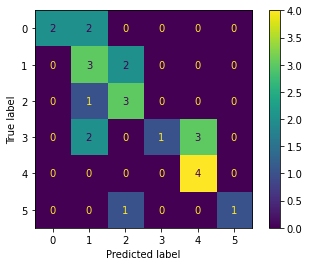

In [89]:
pipeline = Pipeline([
    ("rf", RandomForestClassifier(
        n_jobs=-1, criterion='entropy', 
        min_samples_split= rf_pca_model['rf__min_samples_split'], 
        max_depth= rf_pca_model['rf__max_depth']))
])

pipeline.fit(x_train, y_train)
preds = pipeline.predict(x_test)

rf_pca_acc = accuracy_score(y_test, preds)
rf_pca_prec = precision_score(y_test, preds, average='weighted')
rf_pca_rec = recall_score(y_test, preds, average='weighted')
rf_pca_f1 = f1_score(y_test, preds, average='weighted')

print("Métricas\n")
print("Acurácia ", rf_pca_acc)
print("Precisão ", rf_pca_prec)
print("Revocação ", rf_pca_rec)
print("F1 ", rf_pca_f1)

plot_confusion_matrix(pipeline, x_test, y_test)

In [90]:
print("Melhores parâmetros: ", rf_pca_kmeans_model)

Melhores parâmetros:  {'rf__min_samples_split': 29, 'rf__max_depth': 57, 'kmeans__n_clusters': 30}


Métricas

Acurácia  0.32
Precisão  0.1733333333333333
Revocação  0.32
F1  0.22363636363636363


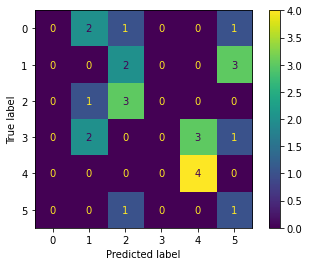

In [91]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters= rf_pca_kmeans_model['kmeans__n_clusters'])),
    ("rf", RandomForestClassifier(
        n_jobs=-1, criterion='entropy', 
        min_samples_split= rf_pca_kmeans_model['rf__min_samples_split'], 
        max_depth= rf_pca_kmeans_model['rf__max_depth']))
])

pipeline.fit(x_train, y_train)
preds = pipeline.predict(x_test)

rf_pca_kmeans_acc = accuracy_score(y_test, preds)
rf_pca_kmeans_prec = precision_score(y_test, preds, average='weighted')
rf_pca_kmeans_rec = recall_score(y_test, preds, average='weighted')
rf_pca_kmeans_f1 = f1_score(y_test, preds, average='weighted')

print("Métricas\n")
print("Acurácia ", rf_pca_kmeans_acc)
print("Precisão ", rf_pca_kmeans_prec)
print("Revocação ", rf_pca_kmeans_rec)
print("F1 ", rf_pca_kmeans_f1)

plot_confusion_matrix(pipeline, x_test, y_test)

In [92]:
print("Melhores parâmetros: ", knn_pca_model)

Melhores parâmetros:  {'knn__n_neighbors': 30}


Métricas

Acurácia  0.2
Precisão  0.22666666666666668
Revocação  0.2
F1  0.11238095238095239


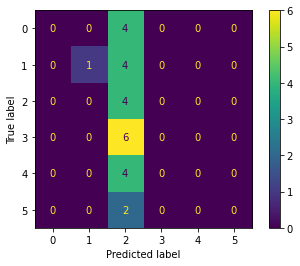

In [93]:
pipeline = Pipeline(steps=[
    ("knn", KNeighborsClassifier(
        n_jobs=-1,
        metric='euclidean'))
])

pipeline.fit(x_train, y_train)
preds = pipeline.predict(x_test)

knn_pca_acc = accuracy_score(y_test, preds)
knn_pca_prec = precision_score(y_test, preds, average='weighted')
knn_pca_rec = recall_score(y_test, preds, average='weighted')
knn_pca_f1 = f1_score(y_test, preds, average='weighted')

print("Métricas\n")
print("Acurácia ", knn_pca_acc)
print("Precisão ", knn_pca_prec)
print("Revocação ", knn_pca_rec)
print("F1 ", knn_pca_f1)

plot_confusion_matrix(pipeline, x_test, y_test)

In [94]:
print("Melhores parâmetros: ", knn_pca_kmeans_model)

Melhores parâmetros:  {'knn__n_neighbors': 6, 'kmeans__n_clusters': 5}


Métricas

Acurácia  0.28
Precisão  0.26476190476190475
Revocação  0.28
F1  0.25807792207792213


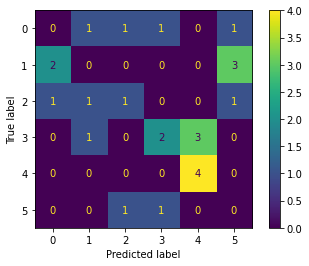

In [95]:
pipeline = Pipeline(steps = [("kmeans", KMeans(n_clusters=knn_pca_kmeans_model['kmeans__n_clusters'])),                     
                             ("knn", KNeighborsClassifier(
                                 n_jobs=-1, 
                                 metric='euclidean', 
                                 n_neighbors=knn_pca_kmeans_model['knn__n_neighbors'])),
])

pipeline.fit(x_train, y_train)
preds = pipeline.predict(x_test)


knn_pca_kmeans_acc = accuracy_score(y_test, preds)
knn_pca_kmeans_prec = precision_score(y_test, preds, average='weighted')
knn_pca_kmeans_rec = recall_score(y_test, preds, average='weighted')
knn_pca_kmeans_f1 = f1_score(y_test, preds, average='weighted')

print("Métricas\n")
print("Acurácia ", knn_pca_kmeans_acc)
print("Precisão ", knn_pca_kmeans_prec)
print("Revocação ", knn_pca_kmeans_rec)
print("F1 ", knn_pca_kmeans_f1)

plot_confusion_matrix(pipeline, x_test, y_test)

In [96]:
print("Melhores parâmetros: ", rl_pca_model)

Melhores parâmetros:  {'rl__C': 0.11102040816326529}


Métricas

Acurácia  0.24
Precisão  0.29692307692307696
Revocação  0.24
F1  0.21875630252100844


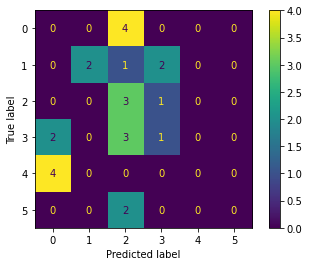

In [97]:
pipeline = Pipeline(steps=[("rl", LogisticRegression(n_jobs=-1, penalty='l2', C=rl_pca_model['rl__C']))])

pipeline.fit(x_train, y_train)
preds = pipeline.predict(x_test)

rl_pca_acc = accuracy_score(y_test, preds)
rl_pca_prec = precision_score(y_test, preds, average='weighted')
rl_pca_rec = recall_score(y_test, preds, average='weighted')
rl_pca_f1 = f1_score(y_test, preds, average='weighted')

print("Métricas\n")
print("Acurácia ", rl_pca_acc)
print("Precisão ", rl_pca_prec)
print("Revocação ", rl_pca_rec)
print("F1 ", rl_pca_f1)

plot_confusion_matrix(pipeline, x_test, y_test)

In [98]:
print("Melhores parâmetros: ", rl_pca_kmeans_model)

Melhores parâmetros:  {'rl__C': 0.19183673469387755, 'kmeans__n_clusters': 9}


Métricas

Acurácia  0.36
Precisão  0.31587301587301586
Revocação  0.36
F1  0.26950649350649347


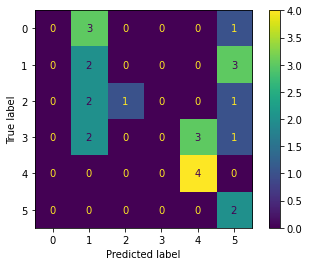

In [99]:
pipeline = Pipeline(steps=[("kmeans", KMeans(n_clusters=rl_pca_kmeans_model['kmeans__n_clusters'])),
                           ("rl", LogisticRegression(n_jobs=-1, penalty='l2', C=rl_pca_kmeans_model['rl__C']))])

pipeline.fit(x_train, y_train)
preds = pipeline.predict(x_test)

rl_pca_kmeans_acc = accuracy_score(y_test, preds)
rl_pca_kmeans_prec = precision_score(y_test, preds, average='weighted')
rl_pca_kmeans_rec = recall_score(y_test, preds, average='weighted')
rl_pca_kmeans_f1 = f1_score(y_test, preds, average='weighted')

print("Métricas\n")
print("Acurácia ", rl_pca_kmeans_acc)
print("Precisão ", rl_pca_kmeans_prec)
print("Revocação ", rl_pca_kmeans_rec)
print("F1 ", rl_pca_kmeans_f1)

plot_confusion_matrix(pipeline, x_test, y_test)

In [100]:
print("Melhores parâmetros: ", xgb_pca_model)

Melhores parâmetros:  {'xgboost__max_depth': 63, 'xgboost__learning_rate': 0.8383673469387755}


Métricas

Acurácia  0.52
Precisão  0.4915555555555555
Revocação  0.52
F1  0.4796190476190476


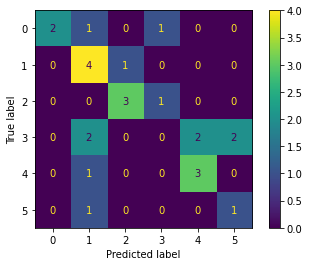

In [101]:
pipeline = Pipeline(steps=[
    ("xgboost", XGBClassifier(
        n_jobs=-1, 
        max_depth=xgb_pca_model['xgboost__max_depth'], 
        learning_rate=xgb_pca_model['xgboost__learning_rate']))
])

pipeline.fit(x_train, y_train)
preds = pipeline.predict(x_test)

xgb_pca_acc = accuracy_score(y_test, preds)
xgb_pca_prec = precision_score(y_test, preds, average='weighted')
xgb_pca_rec = recall_score(y_test, preds, average='weighted')
xgb_pca_f1 = f1_score(y_test, preds, average='weighted')

print("Métricas\n")
print("Acurácia ", xgb_pca_acc)
print("Precisão ", xgb_pca_prec)
print("Revocação ", xgb_pca_rec)
print("F1 ", xgb_pca_f1)

plot_confusion_matrix(pipeline, x_test, y_test)

In [129]:
print("Melhores parâmetros: ", xgb_pca_kmeans_model)

Melhores parâmetros:  {'xgboost__max_depth': 17, 'xgboost__learning_rate': 0.2726530612244898, 'kmeans__n_clusters': 24}


Métricas

Acurácia  0.4
Precisão  0.3325714285714285
Revocação  0.4
F1  0.3474747474747475


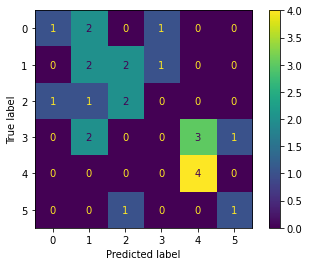

In [130]:
pipeline = Pipeline(steps=[
    ("kmeans", KMeans(n_clusters=xgb_pca_kmeans_model['kmeans__n_clusters'])),
    ("xgboost", XGBClassifier(
        n_jobs=-1, 
        max_depth=xgb_pca_kmeans_model['xgboost__max_depth'], 
        learning_rate=xgb_pca_kmeans_model['xgboost__learning_rate']))
])

pipeline.fit(x_train, y_train)
preds = pipeline.predict(x_test)

xgb_pca_kmeans_acc = accuracy_score(y_test, preds)
xgb_pca_kmeans_prec = precision_score(y_test, preds, average='weighted')
xgb_pca_kmeans_rec = recall_score(y_test, preds, average='weighted')
xgb_pca_kmeans_f1 = f1_score(y_test, preds, average='weighted')

print("Métricas\n")
print("Acurácia ", xgb_pca_kmeans_acc)
print("Precisão ", xgb_pca_kmeans_prec)
print("Revocação ", xgb_pca_kmeans_rec)
print("F1 ", xgb_pca_kmeans_f1)

plot_confusion_matrix(pipeline, x_test, y_test)

#### Relatório das métricas

In [104]:
acc_pca = []
acc_pca.append(rf_pca_acc)
acc_pca.append(knn_pca_acc)
acc_pca.append(rl_pca_acc)
acc_pca.append(xgb_pca_acc)

prec_pca = []
prec_pca.append(rf_pca_prec)
prec_pca.append(knn_pca_prec)
prec_pca.append(rl_pca_prec)
prec_pca.append(xgb_pca_prec)

rec_pca = []
rec_pca.append(rf_pca_rec)
rec_pca.append(knn_pca_rec)
rec_pca.append(rl_pca_rec)
rec_pca.append(xgb_pca_rec)

f1_pca = []
f1_pca.append(rf_pca_f1)
f1_pca.append(knn_pca_f1)
f1_pca.append(rl_pca_f1)
f1_pca.append(xgb_pca_f1)

In [105]:
acc_pca_kmeans = []
acc_pca_kmeans.append(rf_pca_kmeans_acc)
acc_pca_kmeans.append(knn_pca_kmeans_acc)
acc_pca_kmeans.append(rl_pca_kmeans_acc)
acc_pca_kmeans.append(xgb_pca_kmeans_acc)

prec_pca_kmeans = []
prec_pca_kmeans.append(rf_pca_kmeans_prec)
prec_pca_kmeans.append(knn_pca_kmeans_prec)
prec_pca_kmeans.append(rl_pca_kmeans_prec)
prec_pca_kmeans.append(xgb_pca_kmeans_prec)

rec_pca_kmeans = []
rec_pca_kmeans.append(rf_pca_kmeans_rec)
rec_pca_kmeans.append(knn_pca_kmeans_rec)
rec_pca_kmeans.append(rl_pca_kmeans_rec)
rec_pca_kmeans.append(xgb_pca_kmeans_rec)

f1_pca_kmeans = []
f1_pca_kmeans.append(rf_pca_kmeans_f1)
f1_pca_kmeans.append(knn_pca_kmeans_f1)
f1_pca_kmeans.append(rl_pca_kmeans_f1)
f1_pca_kmeans.append(xgb_pca_kmeans_f1)

#### Gráfico de linhas

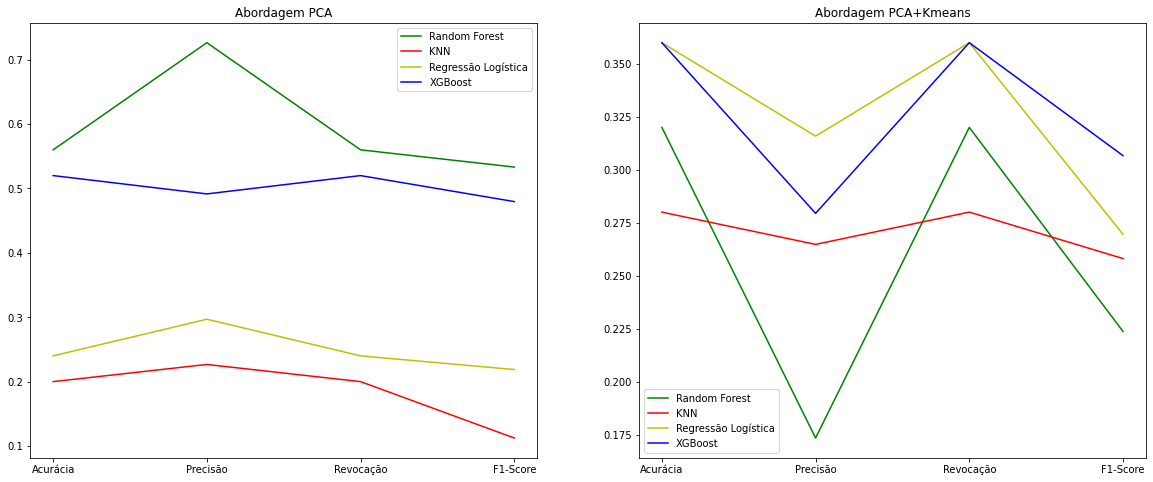

In [106]:
metrics = ["Acurácia", "Precisão", "Revocação", "F1-Score"]
rf_metrics, knn_metrics, rl_metrics, xgb_metrics = np.array([acc_pca, prec_pca, rec_pca, f1_pca]).T
rf_metrics_kmeans, knn_metrics_kmeans, rl_metrics_kmeans, xgb_metrics_kmeans = np.array([acc_pca_kmeans, prec_pca_kmeans, rec_pca_kmeans, f1_pca_kmeans]).T

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

ax1.set_title("Abordagem PCA")
ax1.plot(metrics, rf_metrics, 'g', label="Random Forest")
ax1.plot(metrics, knn_metrics, 'r', label="KNN")
ax1.plot(metrics, rl_metrics, 'y', label="Regressão Logística")
ax1.plot(metrics, xgb_metrics, 'b', label="XGBoost")
ax1.legend()

ax2.set_title("Abordagem PCA+Kmeans")
ax2.plot(metrics, rf_metrics_kmeans, 'g', label="Random Forest")
ax2.plot(metrics, knn_metrics_kmeans, 'r', label="KNN")
ax2.plot(metrics, rl_metrics_kmeans, 'y', label="Regressão Logística")
ax2.plot(metrics, xgb_metrics_kmeans, 'b', label="XGBoost")
ax2.legend()

#### Métricas - abordagem PCA+Kmeans

In [107]:
rf_metrics = {
    'Acurácia': rf_pca_acc, 
    'Precisão': rf_pca_prec,
    'Revocação': rf_pca_rec,
    'F1-score': rf_pca_f1
}

knn_metrics = {
    'Acurácia': knn_pca_acc,
    'Precisão': knn_pca_prec,
    'Revocação': knn_pca_rec,
    'F1-score': knn_pca_f1
}

rl_metrics = {
    'Acurácia': rl_pca_acc,
    'Precisão': rl_pca_prec,
    'Revocação': rl_pca_rec,
    'F1-score': rl_pca_f1
}

xgb_metrics = {
    'Acurácia': xgb_pca_acc,
    'Precisão': xgb_pca_prec,
    'Revocação': xgb_pca_rec,
    'F1-score': xgb_pca_f1
}

#### Gráfico de barras

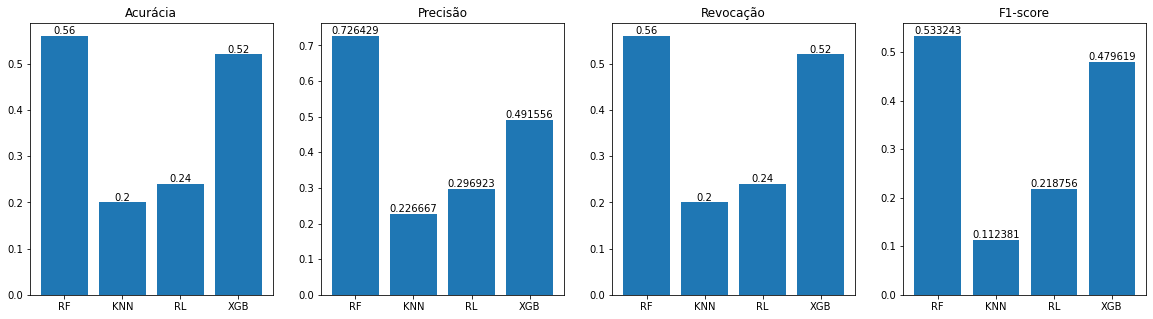

In [108]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20, 5))

ax0.set_title("Acurácia")
sets = ['RF', 'KNN', 'RL', 'XGB']
values = [rf_metrics['Acurácia'], knn_metrics['Acurácia'], rl_metrics['Acurácia'], xgb_metrics['Acurácia']]
bar = ax0.bar(sets, values)
ax0.bar_label(bar)

ax1.set_title("Precisão")
sets = ['RF', 'KNN', 'RL', 'XGB']
values = [rf_metrics['Precisão'], knn_metrics['Precisão'], rl_metrics['Precisão'], xgb_metrics['Precisão']]
bar = ax1.bar(sets, values)
ax1.bar_label(bar)

ax2.set_title("Revocação")
sets = ['RF', 'KNN', 'RL', 'XGB']
values = [rf_metrics['Revocação'], knn_metrics['Revocação'], rl_metrics['Revocação'], xgb_metrics['Revocação']]
bar = ax2.bar(sets, values)
ax2.bar_label(bar)

ax3.set_title("F1-score")
sets = ['RF', 'KNN', 'RL', 'XGB']
values = [rf_metrics['F1-score'], knn_metrics['F1-score'], rl_metrics['F1-score'], xgb_metrics['F1-score']]
bar = ax3.bar(sets, values)
ax3.bar_label(bar)

plt.savefig('models/metrics_pca.png', format='png')
plt.show()

#### Métricas - abordagem PCA+Kmeans

In [109]:
rf_metrics_kmeans = {
    'Acurácia': rf_pca_kmeans_acc, 
    'Precisão': rf_pca_kmeans_prec,
    'Revocação': rf_pca_kmeans_rec,
    'F1-score': rf_pca_kmeans_f1
}

knn_metrics_kmeans = {
    'Acurácia': knn_pca_kmeans_acc,
    'Precisão': knn_pca_kmeans_prec,
    'Revocação': knn_pca_kmeans_rec,
    'F1-score': knn_pca_kmeans_f1
}

rl_metrics_kmeans = {
    'Acurácia': rl_pca_kmeans_acc,
    'Precisão': rl_pca_kmeans_prec,
    'Revocação': rl_pca_kmeans_rec,
    'F1-score': rl_pca_kmeans_f1
}

xgb_metrics_kmeans = {
    'Acurácia': xgb_pca_kmeans_acc,
    'Precisão': xgb_pca_kmeans_prec,
    'Revocação': xgb_pca_kmeans_rec,
    'F1-score': xgb_pca_kmeans_f1
}

#### Gráfico de barras

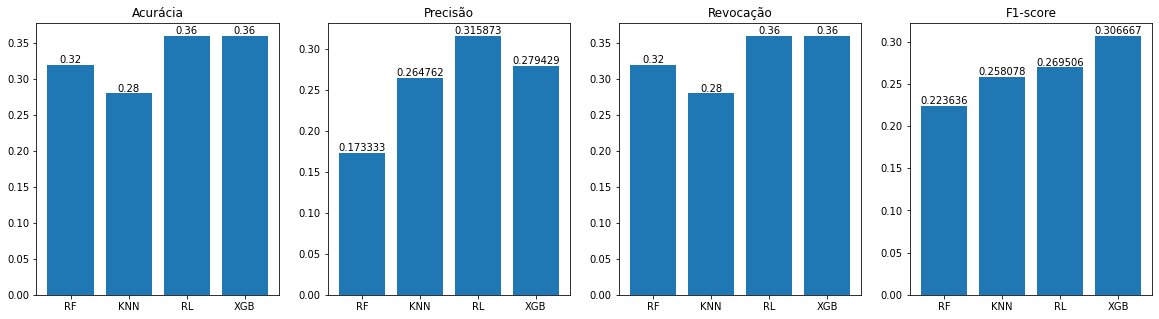

In [110]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20, 5))

ax0.set_title("Acurácia")
sets = ['RF', 'KNN', 'RL', 'XGB']
values = [rf_metrics_kmeans['Acurácia'], knn_metrics_kmeans['Acurácia'], rl_metrics_kmeans['Acurácia'], xgb_metrics_kmeans['Acurácia']]
bar = ax0.bar(sets, values)
ax0.bar_label(bar)

ax1.set_title("Precisão")
sets = ['RF', 'KNN', 'RL', 'XGB']
values = [rf_metrics_kmeans['Precisão'], knn_metrics_kmeans['Precisão'], rl_metrics_kmeans['Precisão'], xgb_metrics_kmeans['Precisão']]
bar = ax1.bar(sets, values)
ax1.bar_label(bar)

ax2.set_title("Revocação")
sets = ['RF', 'KNN', 'RL', 'XGB']
values = [rf_metrics_kmeans['Revocação'], knn_metrics_kmeans['Revocação'], rl_metrics_kmeans['Revocação'], xgb_metrics_kmeans['Revocação']]
bar = ax2.bar(sets, values)
ax2.bar_label(bar)

ax3.set_title("F1-score")
sets = ['RF', 'KNN', 'RL', 'XGB']
values = [rf_metrics_kmeans['F1-score'], knn_metrics_kmeans['F1-score'], rl_metrics_kmeans['F1-score'], xgb_metrics_kmeans['F1-score']]
bar = ax3.bar(sets, values)
ax3.bar_label(bar)

plt.savefig('models/metrics_pca_kmeans.png', format='png')
plt.show()

#### Distribuição das classes

<AxesSubplot:ylabel='class'>

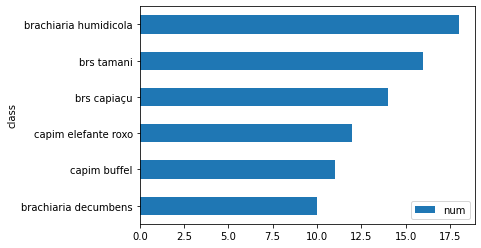

In [111]:
Y['num'] = 1

Y.groupby('class').agg({'num': 'sum'}).sort_values('num').plot(kind='barh', y='num')

In [112]:
Y.shape

(81, 2)

#### Tabela das métricas - PCA

In [113]:
metrics_df = pd.DataFrame.from_dict(data={
    'Modelo': ['Random Forest', 'KNN', 'Regressão Logística', 'XGBoost', 'Random Forest+Kmeans', 'KNN+Kmeans', 'Regressão Logística+Kmeans', 'XGBoost+Kmeans'],
    'Acurácia': [rf_pca_acc, knn_pca_acc, rl_pca_acc, xgb_pca_acc, rf_pca_kmeans_acc, knn_pca_kmeans_acc, rl_pca_kmeans_acc, xgb_pca_kmeans_acc],
    'Precisão': [rf_pca_prec, knn_pca_prec, rl_pca_prec, xgb_pca_prec, rf_pca_kmeans_prec, knn_pca_kmeans_prec, rl_pca_kmeans_prec, xgb_pca_kmeans_prec],
    'Revocação': [rf_pca_rec, knn_pca_rec, rl_pca_rec, xgb_pca_rec, rf_pca_kmeans_rec, knn_pca_kmeans_rec, rl_pca_kmeans_rec, xgb_pca_kmeans_rec],
    'F1-score': [rf_pca_f1, knn_pca_f1, rl_pca_f1, xgb_pca_f1, rf_pca_kmeans_f1, knn_pca_kmeans_f1, rl_pca_kmeans_f1, xgb_pca_kmeans_f1],
    'Média dos scores': [rf_pca_scores, knn_pca_scores, rl_pca_scores, xgb_pca_scores, rf_pca__kmeans_scores, knn_pca_kmeans_scores, rl_pca_kmeans_scores, xgb_pca_kmeans_scores]
}, orient='columns')

In [114]:
metrics_df.sort_values('Acurácia', ascending=False)

,Modelo,Acurácia,Precisão,Revocação,F1-score,Média dos scores
0,Random Forest,0.56,0.726429,0.56,0.533243,1.000000
3,XGBoost,0.52,0.491556,0.52,0.479619,1.000000
6,Regressão Logística+Kmeans,0.36,0.315873,0.36,0.269506,0.500000
7,XGBoost+Kmeans,0.36,0.279429,0.36,0.306667,1.000000
4,Random Forest+Kmeans,0.32,0.173333,0.32,0.223636,0.500000
5,KNN+Kmeans,0.28,0.264762,0.28,0.258078,0.589286
2,Regressão Logística,0.24,0.296923,0.24,0.218756,1.000000
1,KNN,0.20,0.226667,0.20,0.112381,0.178571


In [115]:
metrics_df.sort_values('Acurácia', ascending=False).to_latex("models/metrics_df.tex", index=False)

In [116]:
with open('models/metrics_pca_df.tex','w') as tf:
    tf.write(metrics_df.to_latex(index=False))

In [117]:
metrics_df.to_latex(index=False)

'\\begin{tabular}{lrrrrr}\n\\toprule\n                    Modelo &  Acurácia &  Precisão &  Revocação &  F1-score &  Média dos scores \\\\\n\\midrule\n             Random Forest &      0.56 &  0.726429 &       0.56 &  0.533243 &          1.000000 \\\\\n                       KNN &      0.20 &  0.226667 &       0.20 &  0.112381 &          0.178571 \\\\\n       Regressão Logística &      0.24 &  0.296923 &       0.24 &  0.218756 &          1.000000 \\\\\n                   XGBoost &      0.52 &  0.491556 &       0.52 &  0.479619 &          1.000000 \\\\\n      Random Forest+Kmeans &      0.32 &  0.173333 &       0.32 &  0.223636 &          0.500000 \\\\\n                KNN+Kmeans &      0.28 &  0.264762 &       0.28 &  0.258078 &          0.589286 \\\\\nRegressão Logística+Kmeans &      0.36 &  0.315873 &       0.36 &  0.269506 &          0.500000 \\\\\n            XGBoost+Kmeans &      0.36 &  0.279429 &       0.36 &  0.306667 &          1.000000 \\\\\n\\bottomrule\n\\end{tabular}\n'

#### Tabela das métricas - PCA+Kmeans

In [118]:
metrics_kmeans_df = pd.DataFrame.from_dict(data={
    'Modelo': ['Random Forest+Kmeans', 'KNN+Kmeans', 'Regressão Logística+Kmeans', 'XGBoost+Kmeans'],
    'Acurácia': [rf_pca_kmeans_acc, knn_pca_kmeans_acc, rl_pca_kmeans_acc, xgb_pca_kmeans_acc],
    'Precisão': [rf_pca_kmeans_prec, knn_pca_kmeans_prec, rl_pca_kmeans_prec, xgb_pca_kmeans_prec],
    'Revocação': [rf_pca_kmeans_rec, knn_pca_kmeans_rec, rl_pca_kmeans_rec, xgb_pca_kmeans_rec],
    'F1-score': [rf_pca_kmeans_f1, knn_pca_kmeans_f1, rl_pca_kmeans_f1, xgb_pca_kmeans_f1],
    'Score Mean': [rf_pca__kmeans_scores, knn_pca_kmeans_scores, rl_pca_kmeans_scores, xgb_pca_kmeans_scores]
}, orient='columns')

In [119]:
with open('models/metrics_pca_kmeans_df.tex','w') as tf:
    tf.write(metrics_kmeans_df.to_latex(index=False))

In [120]:
metrics_kmeans_df.to_latex(index=False)

'\\begin{tabular}{lrrrrr}\n\\toprule\n                    Modelo &  Acurácia &  Precisão &  Revocação &  F1-score &  Score Mean \\\\\n\\midrule\n      Random Forest+Kmeans &      0.32 &  0.173333 &       0.32 &  0.223636 &    0.500000 \\\\\n                KNN+Kmeans &      0.28 &  0.264762 &       0.28 &  0.258078 &    0.589286 \\\\\nRegressão Logística+Kmeans &      0.36 &  0.315873 &       0.36 &  0.269506 &    0.500000 \\\\\n            XGBoost+Kmeans &      0.36 &  0.279429 &       0.36 &  0.306667 &    1.000000 \\\\\n\\bottomrule\n\\end{tabular}\n'

#### Tabela das métricas - Meta Learner

In [121]:
metrics_meta_df = pd.DataFrame.from_dict(data={
    'Modelo': ['ResNet-18 + MAML', 'ResNet-18'],
    'Acurácia': [0.8799999952316284, 0.5882353186607361],
    'Precisão': [0.8700000047683716, 0.4933333694934845],
    'Revocação': [0.9100000262260437, 0.5800000429153442],
    'F1-score': [0.8600000143051147, 0.5142857432365417]
}, orient='columns')

In [122]:
metrics_meta_df

,Modelo,Acurácia,Precisão,Revocação,F1-score
0,ResNet-18 + MAML,0.880000,0.870000,0.91,0.860000
1,ResNet-18,0.588235,0.493333,0.58,0.514286


In [123]:
with open('models/metrics_meta_df.tex','w') as tf:
    tf.write(metrics_meta_df.to_latex(index=False))

In [124]:
metrics_meta_df.to_latex(index=False)

'\\begin{tabular}{lrrrr}\n\\toprule\n          Modelo &  Acurácia &  Precisão &  Revocação &  F1-score \\\\\n\\midrule\nResNet-18 + MAML &  0.880000 &  0.870000 &       0.91 &  0.860000 \\\\\n       ResNet-18 &  0.588235 &  0.493333 &       0.58 &  0.514286 \\\\\n\\bottomrule\n\\end{tabular}\n'